In [162]:
import sys

sys.path.append('../xor_neuron')

In [163]:
%matplotlib inline
# produce vector inline graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt

In [164]:
import pickle
from glob import glob
import os
import yaml
from easydict import EasyDict as edict
import numpy as np
import torch
from scipy.signal import convolve2d, fftconvolve, convolve
from scipy.stats import multivariate_normal
from scipy.optimize import curve_fit
from scipy.spatial.distance import cosine

import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.backends.backend_pdf import PdfPages

from model import *
from utils.train_helper import save_outphase, make_mask, load_model

In [165]:
import torch.nn as nn

In [166]:
def quad_func(x, c):
    y = np.zeros((x.shape[0],1))
    for i in range(x.shape[0]):
        y[i] = c[0]*x[i,0]**2 + c[1]*x[i,1]**2 + c[2]*x[i,0]*x[i,1] + c[3]*x[i,0] + c[4]*x[i,1] + c[5]
    return y

def quad_scalar_func(x, c0, c1, c2, c3, c4, c5):
    return c0*x[0]**2 + c1*x[1]**2 + c2*x[0]*x[1] + c3*x[0] + c4*x[1] + c5

In [167]:
dirs = glob('../Resnet20_Xor_V3/*')
dirs.sort(key=os.path.abspath)
# dirs = dirs[1:]

In [168]:
dirs

['../Resnet20_Xor_V3/Xor_ResNet_1_cifar10_161419',
 '../Resnet20_Xor_V3/Xor_ResNet_2_cifar10_161422',
 '../Resnet20_Xor_V3/Xor_ResNet_3_cifar10_161425',
 '../Resnet20_Xor_V3/Xor_ResNet_4_cifar10_161428']

In [169]:
epoch = np.arange(600)

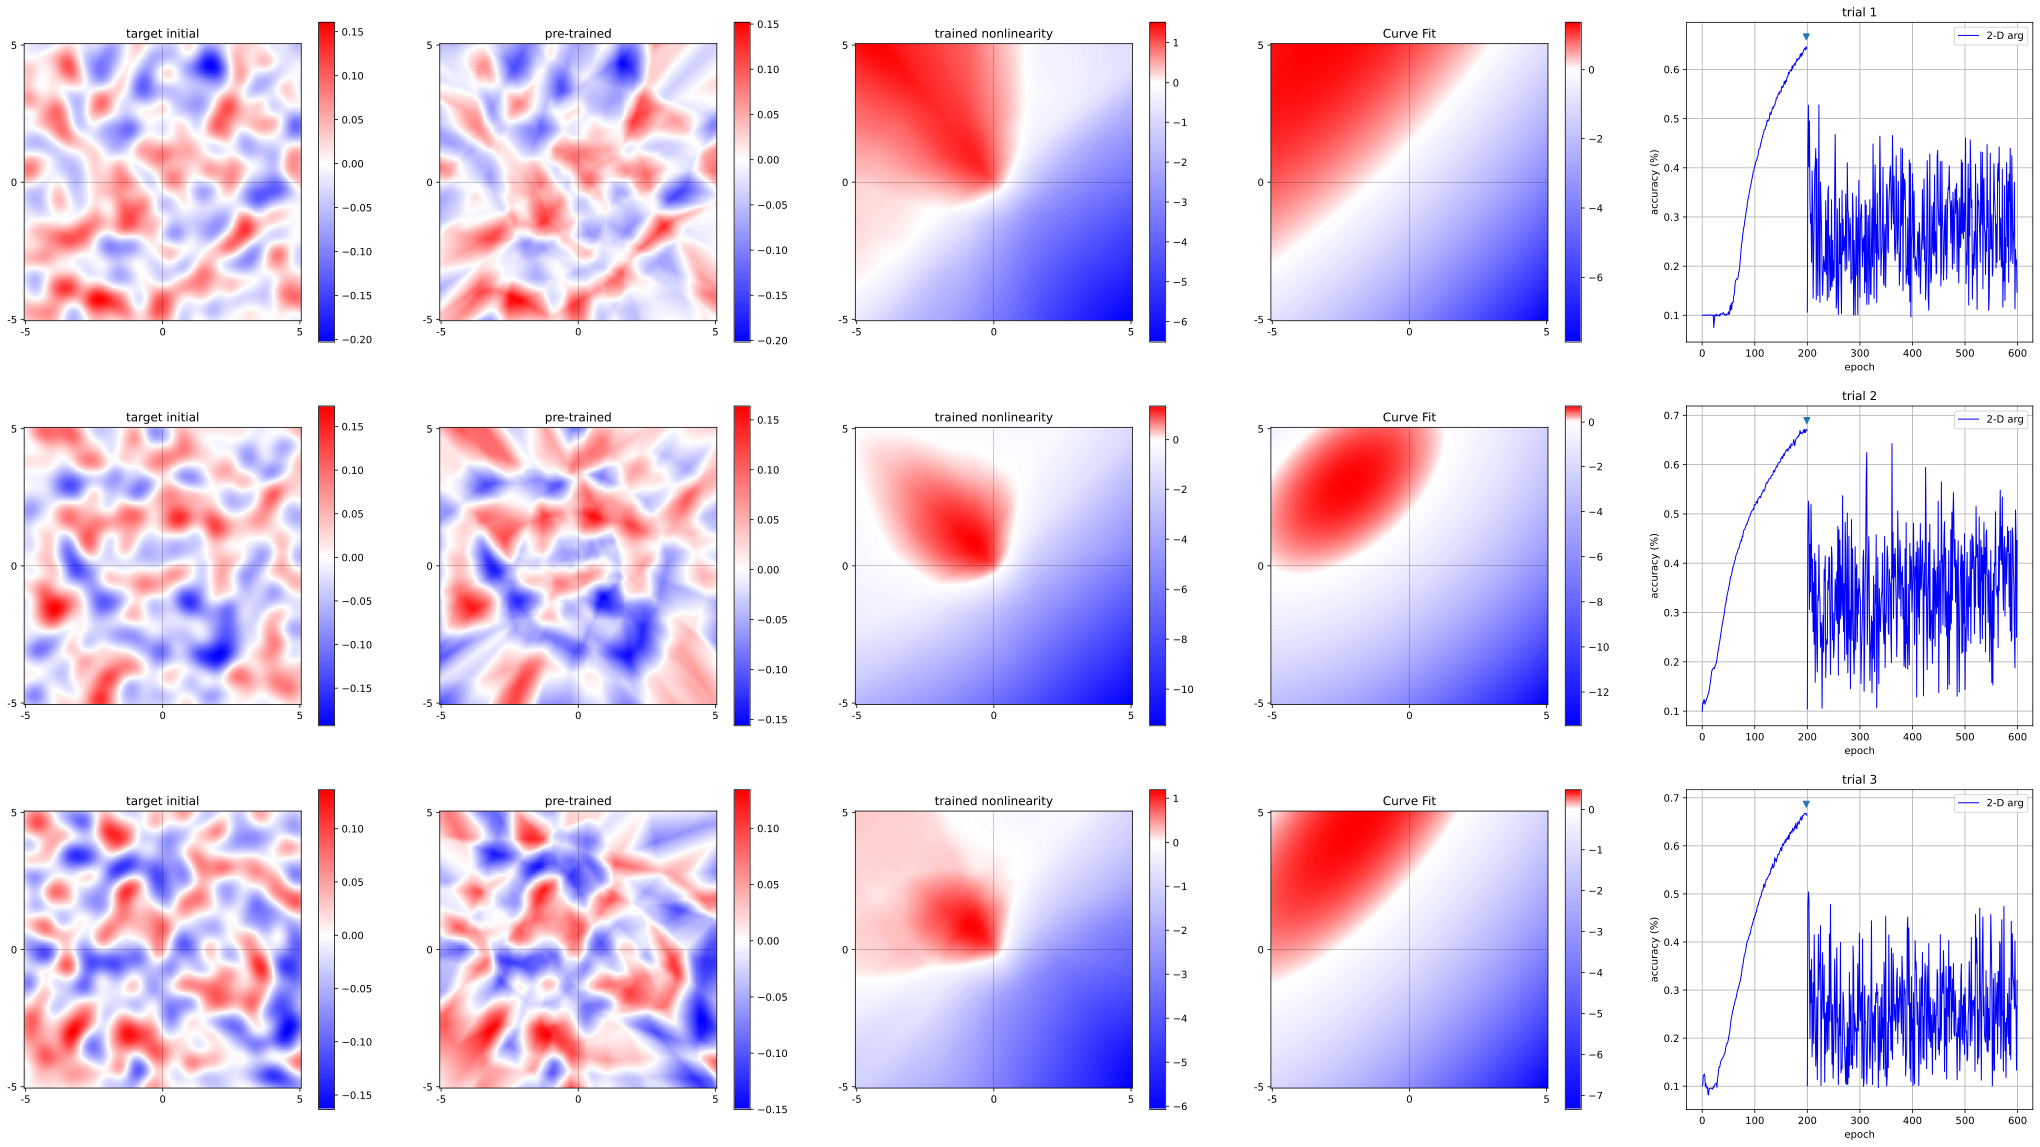

In [172]:
f, axes = plt.subplots(nrows=len(dirs)-1, ncols=5, figsize=(36, 5*len(dirs)), dpi=70)

for ii, dr in enumerate(dirs[:-1]):
    phase1_file = glob(dr + '/train_stats_phase1.p')[0]
    phase2_file = glob(dr + '/train_stats_phase2.p')[0]
    phase1_data = pickle.load(open(phase1_file, 'rb'))
    phase2_data = pickle.load(open(phase2_file, 'rb'))
    target_file = glob(dr + '/pretrain_target.p')[0]
    target = pickle.load(open(target_file, 'rb'))
    
#     auto_attack_result = pickle.load(open(dr+'/auto_attack_result.p', 'rb'))
#     print(auto_attack_result)
    
    config_file = glob(dr + '/*.yaml')[0]
    config = edict(yaml.load(open(config_file, 'r'), Loader=yaml.FullLoader))
    
    
    best = 0
    for i in range(len(phase1_data['val_loss'])):
        if phase1_data['val_loss'][i] == phase1_data['best_val_loss']:
            best = i
    
    # ========== Column 6: Model Accuracy ==============
    axes[ii,4].plot(epoch[:200], phase1_data['val_acc'], 
                    'b', lw=1, label = '2-D arg')
    axes[ii,4].plot(epoch[200:], phase2_data['val_acc'], 
                    'b', lw=1)
    axes[ii,4].plot(best,phase1_data['val_acc'][best] + 0.02, 'v')
    axes[ii,4].set_xlabel('epoch')
    axes[ii,4].set_ylabel('accuracy (%)')
    
    if config.dataset.name == 'mnist':
        axes[ii,4].set_ylim(0.98,1)
    axes[ii,4].legend()

    axes[ii,4].set_title(f'trial {1+ii}')
    axes[ii,4].grid(True)
    
    # create models
    model_pretrain = InnerNet_V2(config)
    model_phase1 = InnerNet_V2(config)

    # load test model
    load_model(model_pretrain.inner_net, config.model_save + config.pretrain.best_model[0])
    load_model(model_phase1.inner_net, config.model_save + config.train.best_model)
    
#     model_pretrain = model_pretrain.inner_net
#     model_phase1 = model_phase1.inner_net

#     model_snapshot = torch.load(config.model_save + config.train.best_model, map_location=torch.device('cpu'))
    
#     for key in list(model_snapshot['model'].keys()):
#         model_snapshot['model'][key.replace('0', 'inner_net')] = model_snapshot['model'].pop(key)
        
#     model_phase1.load_state_dict(model_snapshot["model"], strict=True)
    
    nb = 101
    x = np.linspace(-5, 5, nb)
    y = np.linspace(-5, 5, nb)
    xv, yv = np.meshgrid(x, y)
    xy = np.vstack([xv.reshape(-1), yv.reshape(-1)]).T
    mvn = multivariate_normal(mean=[0, 0], cov=[[1/4, 0], [0, 1/4]])
    gaussian_kernel = mvn.pdf(xy).reshape(nb, nb)
    gaussian_kernel /= gaussian_kernel.sum()
    
    seed = int(str(config.seed) + '0011')
    npr = np.random.RandomState(seed=seed)
    init_unif = npr.uniform(-1, 1, size=(nb, nb))
#     targets = convolve2d(init_unif, gaussian_kernel, mode='same').reshape(-1,1)
    targets = target
    
    model_pretrain.eval()
    model_phase1.eval()
    
#     sqrt_batch_size = np.int(np.sqrt(xy.shape[0]))
#     assert sqrt_batch_size ** 2 == xy.shape[0]

#     out = xy.T.reshape(1, config.model.arg_in_dim, sqrt_batch_size, sqrt_batch_size)

    out_pretrain = model_pretrain.inner_net(torch.Tensor(xy))
    out_phase1 = model_phase1.inner_net(torch.Tensor(xy))
    
    out_pretrain = out_pretrain.reshape(-1,1)
    out_phase1 = out_phase1.reshape(-1,1)


#     # ========== Column 1: Input distribution ==============
#     input2innerAll = glob(dr+'/in2cells.p')[0]
#     input2innerAll = pickle.load(open(input2innerAll, 'rb'))
#     input2innerAll = np.array(input2innerAll[0])
#     input2innerAll = np.moveaxis(input2innerAll, -1, 0)
#     input2innerAll = input2innerAll.reshape((config.model.arg_in_dim, -1))
    
#     xedges = yedges = np.arange(-5.05,5.1,0.1)
#     pdf, _, _ = np.histogram2d(input2innerAll[0], input2innerAll[1], bins=(xedges, yedges))
#     pdf = convolve2d(pdf, gaussian_kernel, mode='same')
#     pdf /= sum(pdf.flatten())
    
#     threshold = 0.0005
#     while True:
#         row, col = np.where(pdf > threshold)
#         if sum(pdf[row, col]) > 0.9:
#             break
#         else:
#             threshold -= 0.00001

#     mask = np.empty((101, 101))
#     mask[:] = np.nan
#     mask[row, col] = 1
    
#     mask_zero = np.zeros((101,101))
#     mask_zero[row, col] = 1
    
#     cmax = max(pdf.flatten()).round(4)
#     im = axes[ii,0].imshow(mask_zero * pdf, cmap='hot', vmin=0, vmax=cmax)
#     axes[ii,0].set_title('input distribution')
#     axes[ii,0].set_xticks([0, 50, 100])
#     axes[ii,0].set_xticklabels(['-5', '0', '5'])
#     axes[ii,0].set_yticks([0, 50, 100])
#     axes[ii,0].set_yticklabels(['5', '0', '-5'])
#     axes[ii,0].plot([0,100], [50,50], 'w', lw=0.3)
#     axes[ii,0].plot([50,50], [0,100], 'w', lw=0.3)
#     f.colorbar(im, ax=axes[ii,0])
    
    # ========== Column 2: Target Initial ==============
    cmax = max(targets)
    cmin = min(targets)
    norm = colors.TwoSlopeNorm(vmin=cmin, vcenter=0, vmax=cmax)
    im = axes[ii,0].imshow(targets.reshape(101, 101), cmap='bwr', norm = norm)
    axes[ii,0].set_title('target initial')
    axes[ii,0].set_xticks([0, 50, 100])
    axes[ii,0].set_xticklabels(['-5', '0', '5'])
    axes[ii,0].set_yticks([0, 50, 100])
    axes[ii,0].set_yticklabels(['5', '0', '-5'])
    axes[ii,0].plot([0,100], [50,50], 'k', lw=0.2)
    axes[ii,0].plot([50,50], [0,100], 'k', lw=0.2)
    f.colorbar(im, ax=axes[ii,0])
    
    
    # ========== Column 3: Pre-trained  ==============
    out_pretrain = out_pretrain.data.cpu().numpy()
    cmax = max(out_pretrain)
    cmin = min(out_pretrain)
    norm = colors.TwoSlopeNorm(vmin=cmin, vcenter=0, vmax=cmax)
    im = axes[ii,1].imshow(out_pretrain.reshape(101, 101), cmap='bwr', norm = norm)
    axes[ii,1].set_title('pre-trained')
    axes[ii,1].set_xticks([0, 50, 100])
    axes[ii,1].set_xticklabels(['-5', '0', '5'])
    axes[ii,1].set_yticks([0, 50, 100])
    axes[ii,1].set_yticklabels(['5', '0', '-5'])
    axes[ii,1].plot([0,100], [50,50], 'k', lw=0.2)
    axes[ii,1].plot([50,50], [0,100], 'k', lw=0.2)
    f.colorbar(im, ax=axes[ii,1])
    
    
    # ========== Column 4: Trained nonlinearity ==============
    out_phase1 = out_phase1.data.cpu().numpy()
    cmax = max(out_phase1)
    cmin = min(out_phase1)
    norm = colors.TwoSlopeNorm(vmin=cmin, vcenter=0, vmax=cmax)
    im = axes[ii,2].imshow(out_phase1.reshape(101, 101), cmap='bwr', norm = norm)
    axes[ii,2].set_title('trained nonlinearity')
    axes[ii,2].set_xticks([0, 50, 100])
    axes[ii,2].set_xticklabels(['-5', '0', '5'])
    axes[ii,2].set_yticks([0, 50, 100])
    axes[ii,2].set_yticklabels(['5', '0', '-5'])
    axes[ii,2].plot([0,100], [50,50], 'k', lw=0.2)
    axes[ii,2].plot([50,50], [0,100], 'k', lw=0.2)
    f.colorbar(im, ax=axes[ii,2])
    
    # ========= Column 4: Curve fit ===============
    xv_ = xv.reshape(-1)
    yv_ = yv.reshape(-1)
    
    out_phase1 = out_phase1.reshape(-1)
    nan_list = np.argwhere(np.isnan(out_phase1))

    xv_ = xv_[np.logical_not(np.isnan(xv_*out_phase1))]
    yv_ = yv_[np.logical_not(np.isnan(yv_*out_phase1))]
    out_phase1 = out_phase1[np.logical_not(np.isnan(out_phase1))]
    
    xy = np.vstack([xv_, yv_]).T

    popt, pcov = curve_fit(quad_scalar_func, xy.T, out_phase1)
    quad_no_nan = quad_func(xy, popt)
    distance = cosine(out_phase1.flatten(), quad_no_nan.flatten())

    quad_fit = np.zeros(10201)
    j = 0
    for i in range(10201):
        if np.isin(i, nan_list) == False:
            quad_fit[i] = quad_no_nan[j]
            j+=1
    
    cmax = max(quad_fit)
    cmin = min(quad_fit)
    
    if cmax < 0:
        norm = colors.TwoSlopeNorm(vmin=cmin, vcenter=cmax, vmax=0)
    elif cmin > 0:
        norm = colors.TwoSlopeNorm(vmin=0, vcenter=cmin, vmax=cmax)
    else:
        norm = colors.TwoSlopeNorm(vmin=cmin, vcenter=0, vmax=cmax)
    im = axes[ii,3].imshow(quad_fit.reshape(101, 101), cmap='bwr', norm=norm)
    axes[ii,3].set_title('Curve Fit')
    axes[ii,3].set_xticks([0, 50, 100])
    axes[ii,3].set_xticklabels(['-5', '0', '5'])
    axes[ii,3].set_yticks([0, 50, 100])
    axes[ii,3].set_yticklabels(['5', '0', '-5'])
    axes[ii,3].plot([0,100], [50,50], 'k', lw=0.2)
    axes[ii,3].plot([50,50], [0,100], 'k', lw=0.2)
    f.colorbar(im, ax=axes[ii,3])

plt.savefig(f'./temp.pdf')
plt.show()

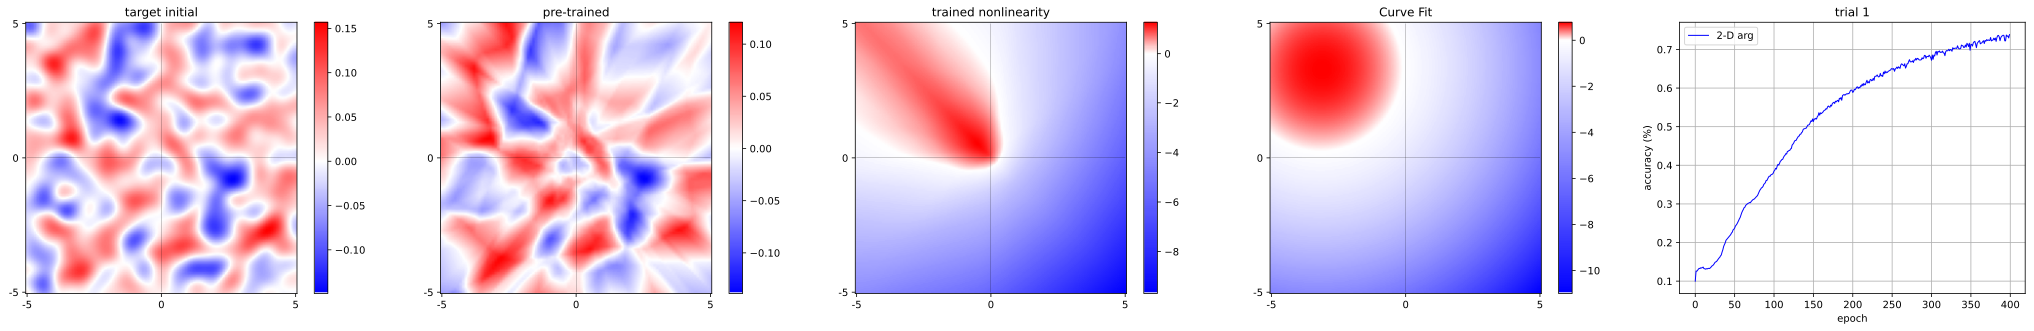

In [161]:
f, axes = plt.subplots(nrows=1, ncols=5, figsize=(36, 5), dpi=70)

for ii, dr in enumerate([dirs[-1]]):
    phase1_file = glob(dr + '/train_stats_phase1.p')[0]
#     phase2_file = glob(dr + '/train_stats_phase2.p')[0]
    phase1_data = pickle.load(open(phase1_file, 'rb'))
#     phase2_data = pickle.load(open(phase2_file, 'rb'))
    target_file = glob(dr + '/pretrain_target.p')[0]
    target = pickle.load(open(target_file, 'rb'))
    
#     auto_attack_result = pickle.load(open(dr+'/auto_attack_result.p', 'rb'))
#     print(auto_attack_result)
    
    config_file = glob(dr + '/*.yaml')[0]
    config = edict(yaml.load(open(config_file, 'r'), Loader=yaml.FullLoader))
    
    
    best = 0
    for i in range(len(phase1_data['val_loss'])):
        if phase1_data['val_loss'][i] == phase1_data['best_val_loss']:
            best = i
    
    # ========== Column 6: Model Accuracy ==============
    axes[4].plot(epoch[:400], phase1_data['val_acc'], 
                    'b', lw=1, label = '2-D arg')
#     axes[4].plot(epoch[200:], phase2_data['val_acc'], 
#                     'b', lw=1)
#     axes[4].plot(best,phase1_data['val_acc'][best] + 0.02, 'v')
    axes[4].set_xlabel('epoch')
    axes[4].set_ylabel('accuracy (%)')
    
    if config.dataset.name == 'mnist':
        axes[4].set_ylim(0.98,1)
    axes[4].legend()

    axes[4].set_title(f'trial {1+ii}')
    axes[4].grid(True)
    
    # create models
    model_pretrain = InnerNet_V2(config)
    model_phase1 = InnerNet_V2(config)

    # load test model
    load_model(model_pretrain.inner_net, config.model_save + config.pretrain.best_model[0])
    load_model(model_phase1.inner_net, config.model_save + config.train.best_model)
    
#     model_pretrain = model_pretrain.inner_net
#     model_phase1 = model_phase1.inner_net

#     model_snapshot = torch.load(config.model_save + config.train.best_model, map_location=torch.device('cpu'))
    
#     for key in list(model_snapshot['model'].keys()):
#         model_snapshot['model'][key.replace('0', 'inner_net')] = model_snapshot['model'].pop(key)
        
#     model_phase1.load_state_dict(model_snapshot["model"], strict=True)
    
    nb = 101
    x = np.linspace(-5, 5, nb)
    y = np.linspace(-5, 5, nb)
    xv, yv = np.meshgrid(x, y)
    xy = np.vstack([xv.reshape(-1), yv.reshape(-1)]).T
    mvn = multivariate_normal(mean=[0, 0], cov=[[1/4, 0], [0, 1/4]])
    gaussian_kernel = mvn.pdf(xy).reshape(nb, nb)
    gaussian_kernel /= gaussian_kernel.sum()
    
    seed = int(str(config.seed) + '0011')
    npr = np.random.RandomState(seed=seed)
    init_unif = npr.uniform(-1, 1, size=(nb, nb))
#     targets = convolve2d(init_unif, gaussian_kernel, mode='same').reshape(-1,1)
    targets = target
    
    model_pretrain.eval()
    model_phase1.eval()
    
#     sqrt_batch_size = np.int(np.sqrt(xy.shape[0]))
#     assert sqrt_batch_size ** 2 == xy.shape[0]

#     out = xy.T.reshape(1, config.model.arg_in_dim, sqrt_batch_size, sqrt_batch_size)

    out_pretrain = model_pretrain.inner_net(torch.Tensor(xy))
    out_phase1 = model_phase1.inner_net(torch.Tensor(xy))
    
    out_pretrain = out_pretrain.reshape(-1,1)
    out_phase1 = out_phase1.reshape(-1,1)


#     # ========== Column 1: Input distribution ==============
#     input2innerAll = glob(dr+'/in2cells.p')[0]
#     input2innerAll = pickle.load(open(input2innerAll, 'rb'))
#     input2innerAll = np.array(input2innerAll[0])
#     input2innerAll = np.moveaxis(input2innerAll, -1, 0)
#     input2innerAll = input2innerAll.reshape((config.model.arg_in_dim, -1))
    
#     xedges = yedges = np.arange(-5.05,5.1,0.1)
#     pdf, _, _ = np.histogram2d(input2innerAll[0], input2innerAll[1], bins=(xedges, yedges))
#     pdf = convolve2d(pdf, gaussian_kernel, mode='same')
#     pdf /= sum(pdf.flatten())
    
#     threshold = 0.0005
#     while True:
#         row, col = np.where(pdf > threshold)
#         if sum(pdf[row, col]) > 0.9:
#             break
#         else:
#             threshold -= 0.00001

#     mask = np.empty((101, 101))
#     mask[:] = np.nan
#     mask[row, col] = 1
    
#     mask_zero = np.zeros((101,101))
#     mask_zero[row, col] = 1
    
#     cmax = max(pdf.flatten()).round(4)
#     im = axes[ii,0].imshow(mask_zero * pdf, cmap='hot', vmin=0, vmax=cmax)
#     axes[ii,0].set_title('input distribution')
#     axes[ii,0].set_xticks([0, 50, 100])
#     axes[ii,0].set_xticklabels(['-5', '0', '5'])
#     axes[ii,0].set_yticks([0, 50, 100])
#     axes[ii,0].set_yticklabels(['5', '0', '-5'])
#     axes[ii,0].plot([0,100], [50,50], 'w', lw=0.3)
#     axes[ii,0].plot([50,50], [0,100], 'w', lw=0.3)
#     f.colorbar(im, ax=axes[ii,0])
    
    # ========== Column 2: Target Initial ==============
    cmax = max(targets)
    cmin = min(targets)
    norm = colors.TwoSlopeNorm(vmin=cmin, vcenter=0, vmax=cmax)
    im = axes[0].imshow(targets.reshape(101, 101), cmap='bwr', norm = norm)
    axes[0].set_title('target initial')
    axes[0].set_xticks([0, 50, 100])
    axes[0].set_xticklabels(['-5', '0', '5'])
    axes[0].set_yticks([0, 50, 100])
    axes[0].set_yticklabels(['5', '0', '-5'])
    axes[0].plot([0,100], [50,50], 'k', lw=0.2)
    axes[0].plot([50,50], [0,100], 'k', lw=0.2)
    f.colorbar(im, ax=axes[0])
    
    
    # ========== Column 3: Pre-trained  ==============
    out_pretrain = out_pretrain.data.cpu().numpy()
    cmax = max(out_pretrain)
    cmin = min(out_pretrain)
    norm = colors.TwoSlopeNorm(vmin=cmin, vcenter=0, vmax=cmax)
    im = axes[1].imshow(out_pretrain.reshape(101, 101), cmap='bwr', norm = norm)
    axes[1].set_title('pre-trained')
    axes[1].set_xticks([0, 50, 100])
    axes[1].set_xticklabels(['-5', '0', '5'])
    axes[1].set_yticks([0, 50, 100])
    axes[1].set_yticklabels(['5', '0', '-5'])
    axes[1].plot([0,100], [50,50], 'k', lw=0.2)
    axes[1].plot([50,50], [0,100], 'k', lw=0.2)
    f.colorbar(im, ax=axes[1])
    
    
    # ========== Column 4: Trained nonlinearity ==============
    out_phase1 = out_phase1.data.cpu().numpy()
    cmax = max(out_phase1)
    cmin = min(out_phase1)
    norm = colors.TwoSlopeNorm(vmin=cmin, vcenter=0, vmax=cmax)
    im = axes[2].imshow(out_phase1.reshape(101, 101), cmap='bwr', norm = norm)
    axes[2].set_title('trained nonlinearity')
    axes[2].set_xticks([0, 50, 100])
    axes[2].set_xticklabels(['-5', '0', '5'])
    axes[2].set_yticks([0, 50, 100])
    axes[2].set_yticklabels(['5', '0', '-5'])
    axes[2].plot([0,100], [50,50], 'k', lw=0.2)
    axes[2].plot([50,50], [0,100], 'k', lw=0.2)
    f.colorbar(im, ax=axes[2])
    
    # ========= Column 4: Curve fit ===============
    xv_ = xv.reshape(-1)
    yv_ = yv.reshape(-1)
    
    out_phase1 = out_phase1.reshape(-1)
    nan_list = np.argwhere(np.isnan(out_phase1))

    xv_ = xv_[np.logical_not(np.isnan(xv_*out_phase1))]
    yv_ = yv_[np.logical_not(np.isnan(yv_*out_phase1))]
    out_phase1 = out_phase1[np.logical_not(np.isnan(out_phase1))]
    
    xy = np.vstack([xv_, yv_]).T

    popt, pcov = curve_fit(quad_scalar_func, xy.T, out_phase1)
    quad_no_nan = quad_func(xy, popt)
    distance = cosine(out_phase1.flatten(), quad_no_nan.flatten())

    quad_fit = np.zeros(10201)
    j = 0
    for i in range(10201):
        if np.isin(i, nan_list) == False:
            quad_fit[i] = quad_no_nan[j]
            j+=1
    
    cmax = max(quad_fit)
    cmin = min(quad_fit)
    
    if cmax < 0:
        norm = colors.TwoSlopeNorm(vmin=cmin, vcenter=cmax, vmax=0)
    elif cmin > 0:
        norm = colors.TwoSlopeNorm(vmin=0, vcenter=cmin, vmax=cmax)
    else:
        norm = colors.TwoSlopeNorm(vmin=cmin, vcenter=0, vmax=cmax)
    im = axes[3].imshow(quad_fit.reshape(101, 101), cmap='bwr', norm=norm)
    axes[3].set_title('Curve Fit')
    axes[3].set_xticks([0, 50, 100])
    axes[3].set_xticklabels(['-5', '0', '5'])
    axes[3].set_yticks([0, 50, 100])
    axes[3].set_yticklabels(['5', '0', '-5'])
    axes[3].plot([0,100], [50,50], 'k', lw=0.2)
    axes[3].plot([50,50], [0,100], 'k', lw=0.2)
    f.colorbar(im, ax=axes[3])

plt.savefig(f'./temp.pdf')
plt.show()

In [122]:
auto_attack_result = pickle.load(open(dr+'/auto_attack_result.p', 'rb'))

In [123]:
auto_attack_result

{'clean': 0.6288, 'apgd-ce': 0.0238, 'apgd-dlr': 0.0144}

In [125]:
xor_model = ResNet20_Xor(config)

In [126]:
xor_model

ResNet_Xor(
  (loss_func): CrossEntropyLoss()
  (inner_net): Sequential(
    (fc1): Linear(in_features=2, out_features=64, bias=True)
    (relu1): ReLU()
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (relu2): ReLU()
    (fc3): Linear(in_features=64, out_features=1, bias=True)
  )
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock_InnerNet(
      (inner_net): Sequential(
        (fc1): Linear(in_features=2, out_features=64, bias=True)
        (relu1): ReLU()
        (fc2): Linear(in_features=64, out_features=64, bias=True)
        (relu2): ReLU()
        (fc3): Linear(in_features=64, out_features=1, bias=True)
      )
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [128]:
orig_resnet20 = resnet20()

In [129]:
orig_resnet20

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=